In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Climalyticsat').getOrCreate()
spark.conf.set("spark.sql.optimizer.maxIterations", 200)

In [2]:
stations_meta = spark.read.option("header", True).option("inferSchema", True).csv("/home/jovyan/work/stations_metadata.csv")


In [3]:
from pyspark.sql.functions import col, to_date

stations_meta = stations_meta \
    .withColumn("start", to_date(col("Startdatum"), "yyyy-MM-dd")) \
    .withColumn("end", to_date(col("Enddatum"), "yyyy-MM-dd")) \
    .withColumnRenamed("id", "station_id") \
    .withColumnRenamed("Bundesland", "bundesland") \
    .withColumnRenamed("Höhe [m]", "altitude")


In [4]:
from pyspark.sql.functions import explode, sequence, year, lit

# Liste aller Jahre erzeugen
years_df = spark.createDataFrame([(y,) for y in range(1960, 2026)], ["year"])

# Cross join
coverage = stations_meta.crossJoin(years_df)

# Filter: Jahr liegt zwischen Start und Ende
coverage = coverage.filter((col("start").isNull() | (col("start") <= to_date(col("year").cast("string"), "yyyy"))) &
                           (col("end").isNull() | (col("end") >= to_date(col("year").cast("string"), "yyyy"))))


In [5]:
from pyspark.sql.functions import when

coverage = coverage.withColumn(
    "elevation_zone",
    when(col("altitude") < 500, "0–499 m (Lowland)")
    .when(col("altitude") < 1000, "500–999 m (Upland)")
    .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
    .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
    .otherwise("2000+ m (High Alpine)")
)


In [6]:
zone_bundesland_pairs = coverage.select("elevation_zone", "bundesland").distinct()


In [7]:
years_df = coverage.select("year").distinct()


In [8]:
valid_combinations = years_df.crossJoin(zone_bundesland_pairs)


In [9]:
from pyspark.sql.functions import count, col, coalesce, lit

actual_counts = coverage.groupBy("year", "elevation_zone", "bundesland") \
    .agg(count("*").alias("count"))


In [10]:
full_coverage = valid_combinations.join(
    actual_counts,
    on=["year", "elevation_zone", "bundesland"],
    how="left"
).withColumn("count", coalesce(col("count"), lit(0)))


In [11]:
gaps = full_coverage.filter(col("count") == 0)


In [12]:
gap_summary = gaps.groupBy("elevation_zone", "bundesland") \
    .count().withColumnRenamed("count", "missing_years")


In [13]:
gap_summary_pd = gap_summary.toPandas()

from pandas.api.types import CategoricalDtype
zone_order = [
    "0–499 m (Lowland)",
    "500–999 m (Upland)",
    "1000–1499 m (Lower Alps)",
    "1500–1999 m (Alpine)",
    "2000+ m (High Alpine)"
]
gap_summary_pd["elevation_zone"] = gap_summary_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)


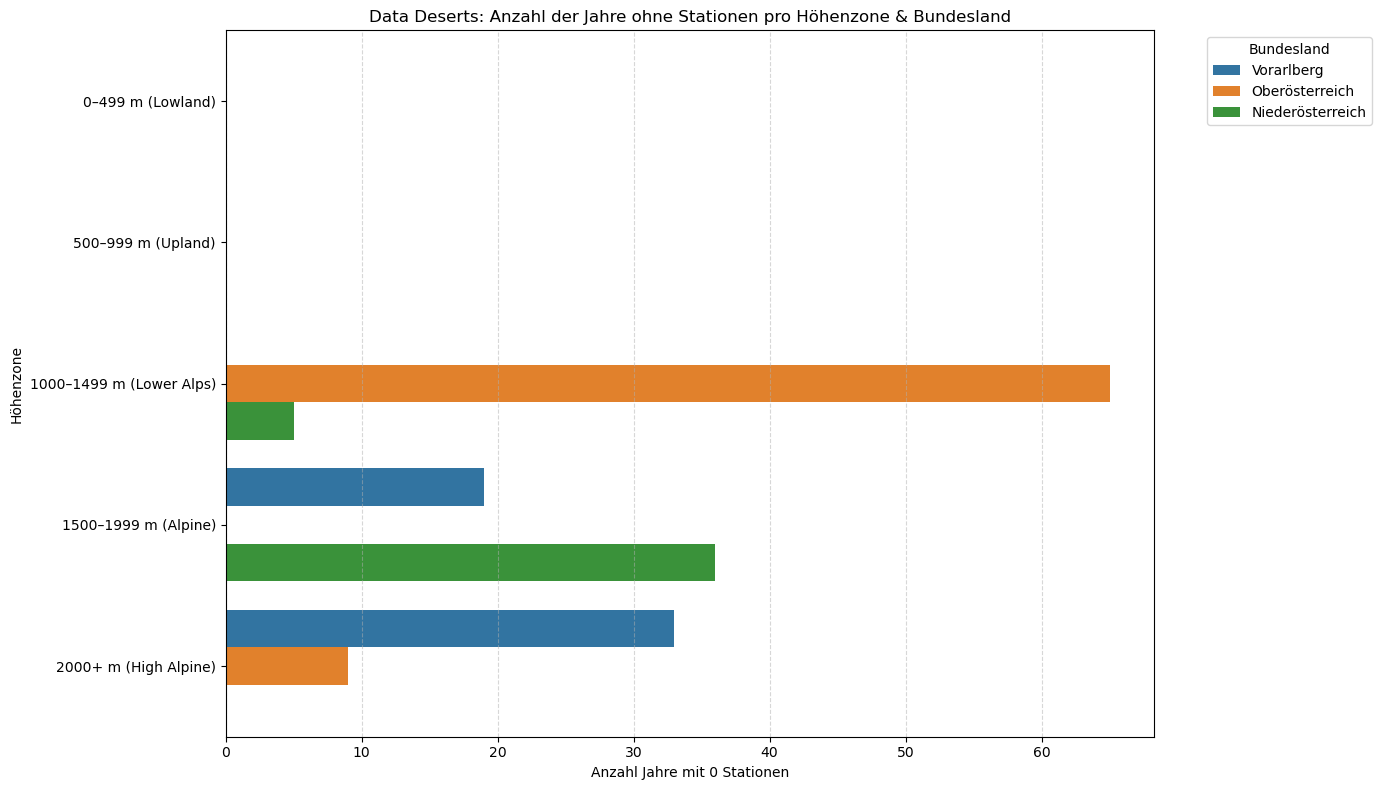

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.barplot(
    data=gap_summary_pd,
    y="elevation_zone",
    x="missing_years",
    hue="bundesland"
)
plt.title("Data Deserts: Anzahl der Jahre ohne Stationen pro Höhenzone & Bundesland")
plt.xlabel("Anzahl Jahre mit 0 Stationen")
plt.ylabel("Höhenzone")
plt.grid(True, axis='x', linestyle="--", alpha=0.5)
plt.legend(title="Bundesland", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [15]:
heatmap_counts = coverage.groupBy("year", "elevation_zone", "bundesland") \
    .agg(count("*").alias("station_count"))


In [16]:
heatmap_pd = heatmap_counts.toPandas()


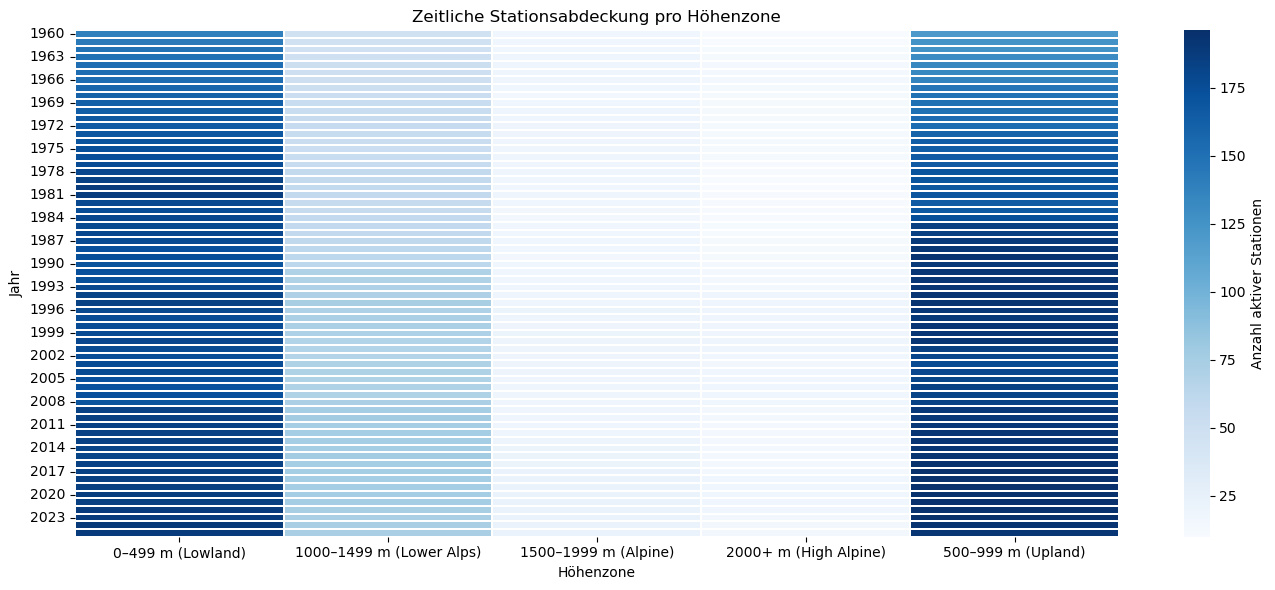

In [17]:
pivot = heatmap_pd.groupby(["year", "elevation_zone"])["station_count"].sum().unstack().fillna(0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="Blues", linewidths=0.3, cbar_kws={"label": "Anzahl aktiver Stationen"})
plt.title("Zeitliche Stationsabdeckung pro Höhenzone")
plt.xlabel("Höhenzone")
plt.ylabel("Jahr")
plt.tight_layout()
plt.show()


In [18]:
# Nutzung des bereits vorhandenen full_coverage mit count pro Jahr, Zone, Bundesland
from pyspark.sql.functions import max as spark_max, min as spark_min

extrema = full_coverage.groupBy("elevation_zone", "bundesland") \
    .agg(
        spark_min("count").alias("min_active"),
        spark_max("count").alias("max_active")
    )

extrema_pd = extrema.toPandas()


In [19]:
heatmap_counts = coverage.groupBy("year", "elevation_zone", "bundesland") \
    .agg(count("*").alias("station_count"))

heatmap_pd = heatmap_counts.toPandas()


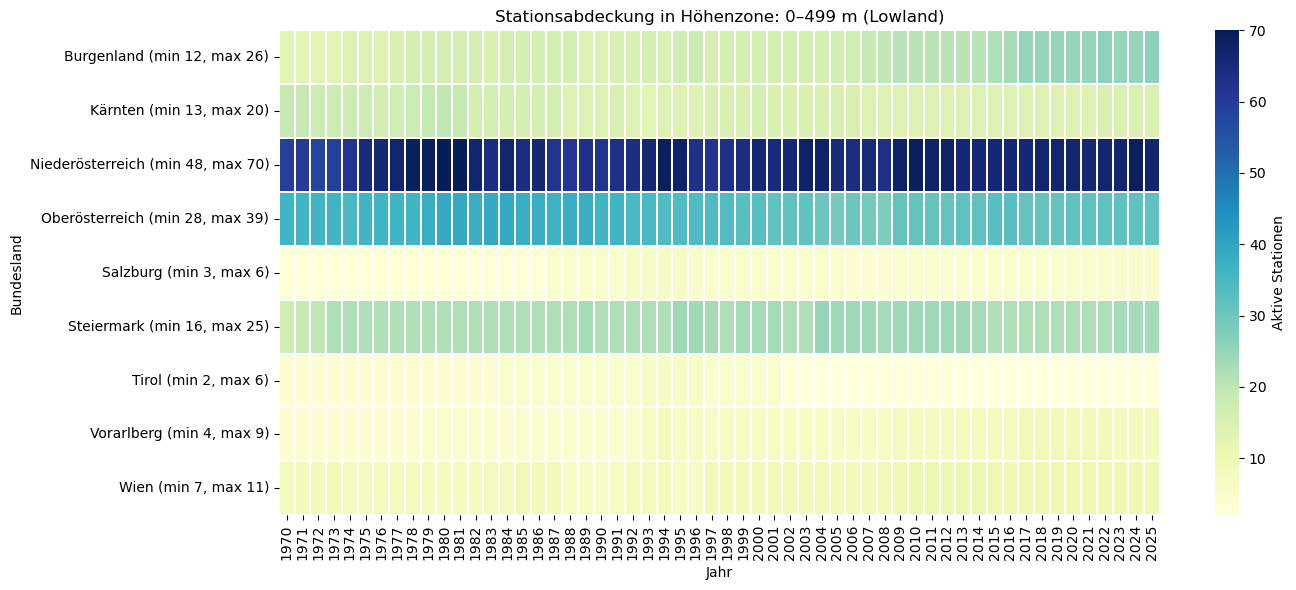

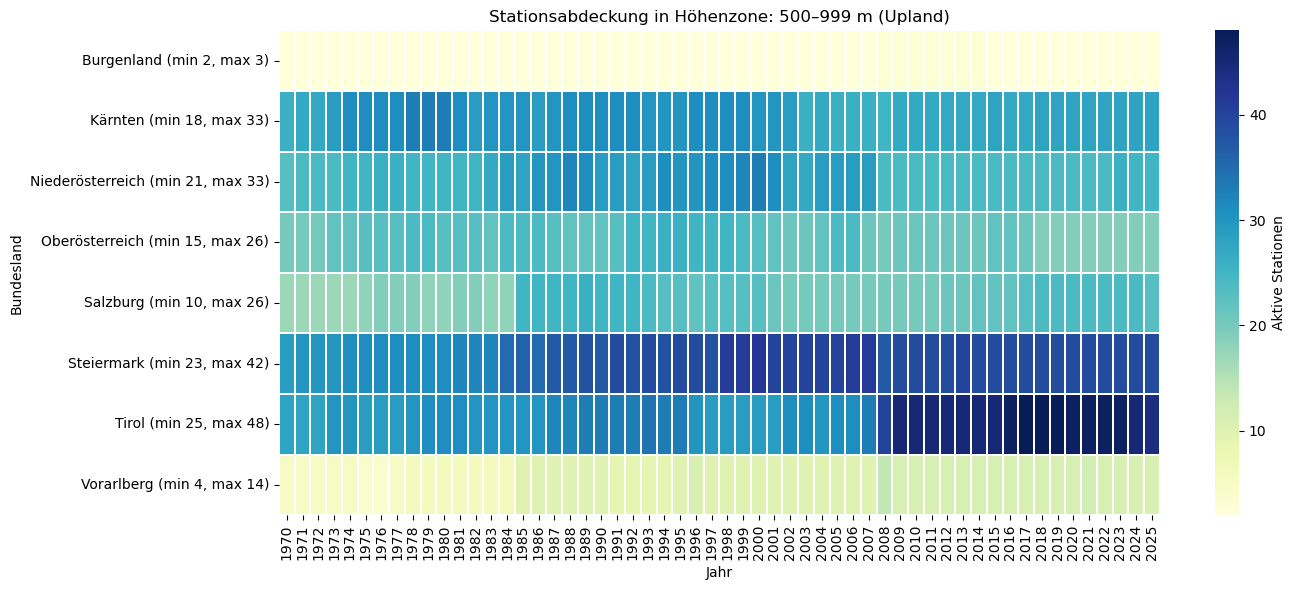

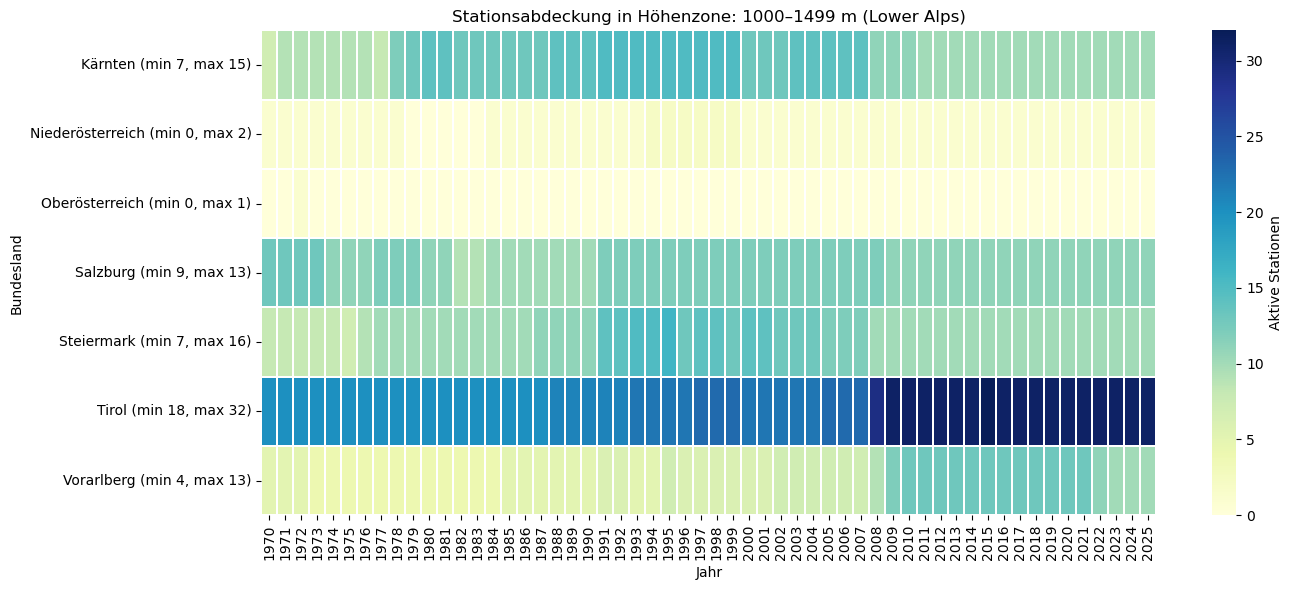

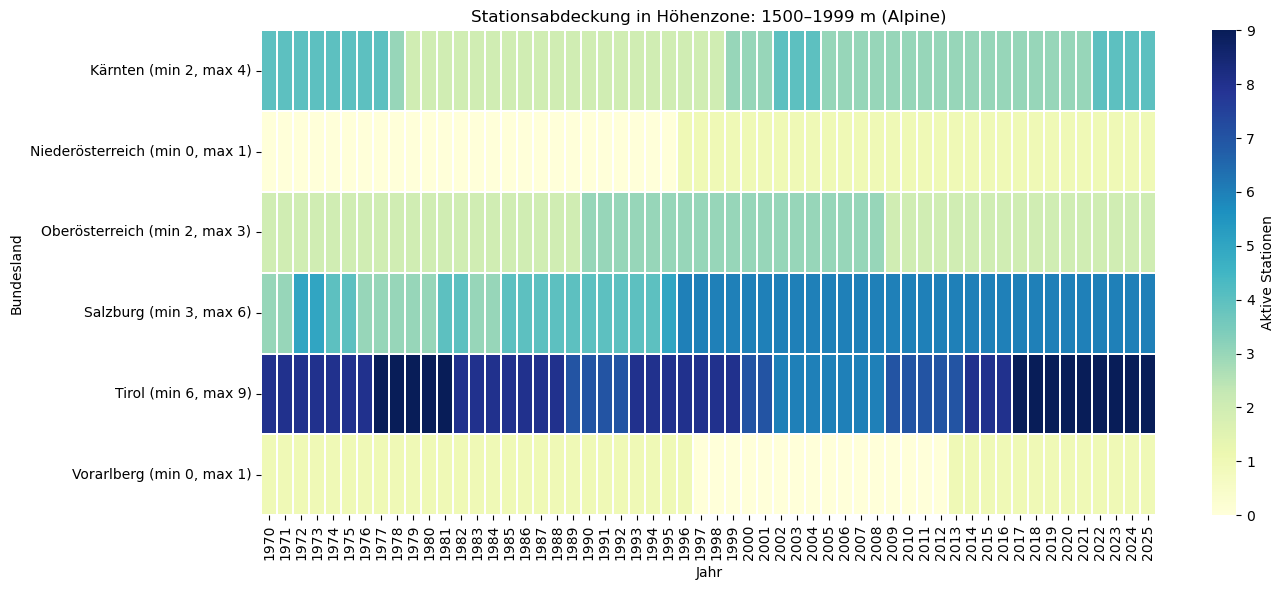

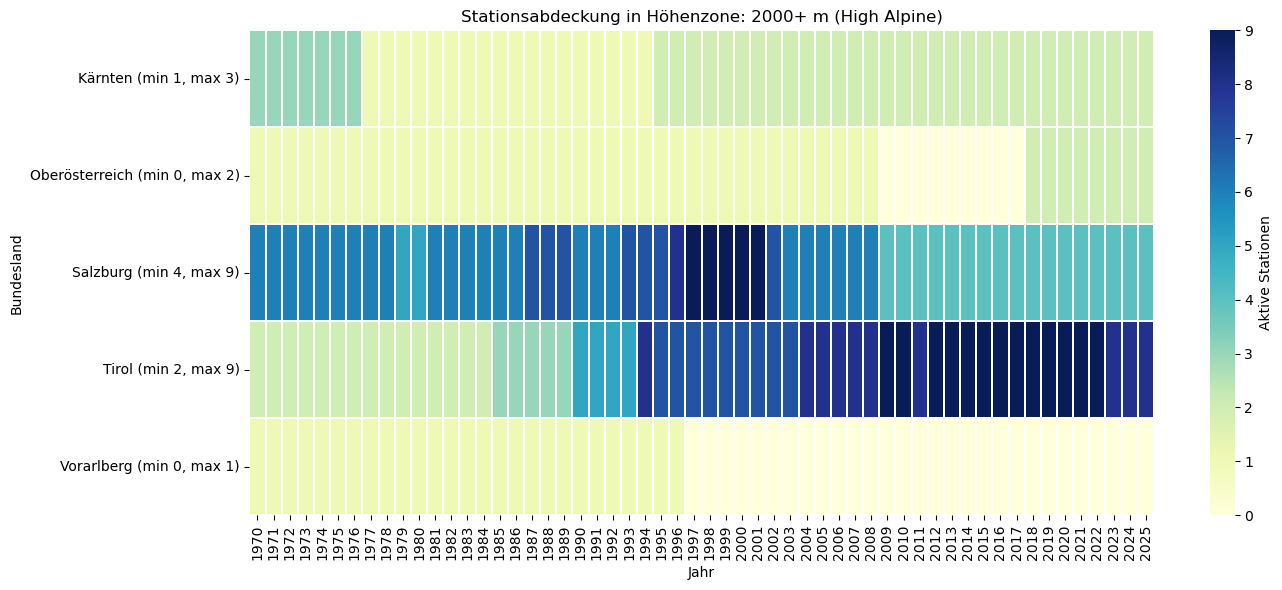

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sortierte Höhenzonen
zone_order = [
    "0–499 m (Lowland)",
    "500–999 m (Upland)",
    "1000–1499 m (Lower Alps)",
    "1500–1999 m (Alpine)",
    "2000+ m (High Alpine)"
]

# (Optional) richtige Sortierung der Zonen setzen
heatmap_pd["elevation_zone"] = heatmap_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)
extrema_pd["elevation_zone"] = extrema_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)



# Iteration pro Höhenzone
for zone in [z for z in zone_order if z in heatmap_pd["elevation_zone"].unique()]:
    df_zone = heatmap_pd[heatmap_pd["elevation_zone"] == zone]

    df_zone = df_zone[df_zone["year"] >= 1970]

    pivot = df_zone.pivot_table(
        index="bundesland",
        columns="year",
        values="station_count",
        fill_value=0
    )

    # Hole min/max aus Spark-Auswertung
    zone_extrema = extrema_pd[extrema_pd["elevation_zone"] == zone]
    min_map = dict(zip(zone_extrema["bundesland"], zone_extrema["min_active"]))
    max_map = dict(zip(zone_extrema["bundesland"], zone_extrema["max_active"]))

    # Neue Y-Achsen-Beschriftung mit min/max
    new_labels = [
        f"{b} (min {min_map.get(b, 0)}, max {max_map.get(b, 0)})"
        for b in pivot.index
    ]

    # Plot
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.3,
                     cbar_kws={"label": "Aktive Stationen"})
    ax.set_title(f"Stationsabdeckung in Höhenzone: {zone}")
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Bundesland")
    ax.set_yticklabels(new_labels, rotation=0)
    plt.tight_layout()
    plt.show()


„Gab es tatsächlich mindestens eine valide Messung in Zone X / Bundesland Y / Jahr Z?“


In [21]:
df = spark.read.parquet("/home/jovyan/work/parquet/climate_all_stations")

print("Anzahl Zeilen im Parquet-DF:", df.count())
df.select("station_id", "date").show(5, truncate=False)
df.select("rr", "tage_frost", "tl_mittel").show(5)


Anzahl Zeilen im Parquet-DF: 752976
+----------+-------------------+
|station_id|date               |
+----------+-------------------+
|57        |1993-01-01 00:00:00|
|57        |1993-02-01 00:00:00|
|57        |1993-03-01 00:00:00|
|57        |1993-04-01 00:00:00|
|57        |1993-05-01 00:00:00|
+----------+-------------------+
only showing top 5 rows

+----+----------+---------+
|  rr|tage_frost|tl_mittel|
+----+----------+---------+
|31.0|      21.0|     -0.2|
|28.0|      27.0|     -3.9|
|15.0|      23.0|      0.6|
|40.0|       9.0|      7.6|
|60.0|       0.0|     14.5|
+----+----------+---------+
only showing top 5 rows



In [22]:
stations_meta = spark.read.option("header", True).option("inferSchema", True).csv("/home/jovyan/work/stations_metadata.csv")

from pyspark.sql.functions import col

stations_meta = stations_meta \
    .withColumn("altitude", col("Höhe [m]")) \
    .withColumnRenamed("id", "station_id") \
    .withColumnRenamed("Bundesland", "bundesland") \
    .select("station_id", "altitude", "bundesland")

# Join mit Metadaten
df = df.join(stations_meta, on="station_id", how="left")

In [23]:
from functools import reduce
from pyspark.sql.functions import lit, col, year, when, countDistinct

# Automatisch Messspalten wählen (alle außer IDs & Metainfo)
measurement_columns = [c for c in df.columns if c not in ["station_id", "date", "altitude", "bundesland"]]

# Filter: mind. ein Messwert nicht leer
any_not_null = reduce(
    lambda acc, c: acc | (~col(c).isNull()),
    measurement_columns,
    lit(False)
)

df_valid = df.filter(any_not_null)

# Zusatzinfos
print("Zeilen nach Filter:", df_valid.count())
print("Zeilen mit NULL-Höhe:", df_valid.filter(col("altitude").isNull()).count())

# Höhenzone und Jahr
df_valid = df_valid \
    .withColumn("year", year("date")) \
    .withColumn(
        "elevation_zone",
        when(col("altitude") < 500, "0–499 m (Lowland)")
        .when(col("altitude") < 1000, "500–999 m (Upland)")
        .when(col("altitude") < 1500, "1000–1499 m (Lower Alps)")
        .when(col("altitude") < 2000, "1500–1999 m (Alpine)")
        .otherwise("2000+ m (High Alpine)")
    )

# Jetzt funktioniert diese Zeile korrekt
coverage_real = df_valid.groupBy("year", "elevation_zone", "bundesland") \
    .agg(countDistinct("station_id").alias("station_count"))


Zeilen nach Filter: 304057
Zeilen mit NULL-Höhe: 0


In [24]:
from pyspark.sql.functions import min as spark_min, max as spark_max

extrema_real = coverage_real.groupBy("elevation_zone", "bundesland") \
    .agg(
        spark_min("station_count").alias("min_active"),
        spark_max("station_count").alias("max_active")
    )

extrema_real_pd = extrema_real.toPandas()


In [25]:
heatmap_pd = coverage_real.toPandas()

print("Einzigartige Höhenzonen in heatmap_pd:")
print(heatmap_pd["elevation_zone"].unique())

Einzigartige Höhenzonen in heatmap_pd:
['500–999 m (Upland)' '0–499 m (Lowland)' '1000–1499 m (Lower Alps)'
 '1500–1999 m (Alpine)' '2000+ m (High Alpine)']


Verfügbare Zonen: ['500–999 m (Upland)', '0–499 m (Lowland)', '1000–1499 m (Lower Alps)', '1500–1999 m (Alpine)', '2000+ m (High Alpine)']
Categories (5, object): ['0–499 m (Lowland)' < '500–999 m (Upland)' < '1000–1499 m (Lower Alps)' < '1500–1999 m (Alpine)' < '2000+ m (High Alpine)']


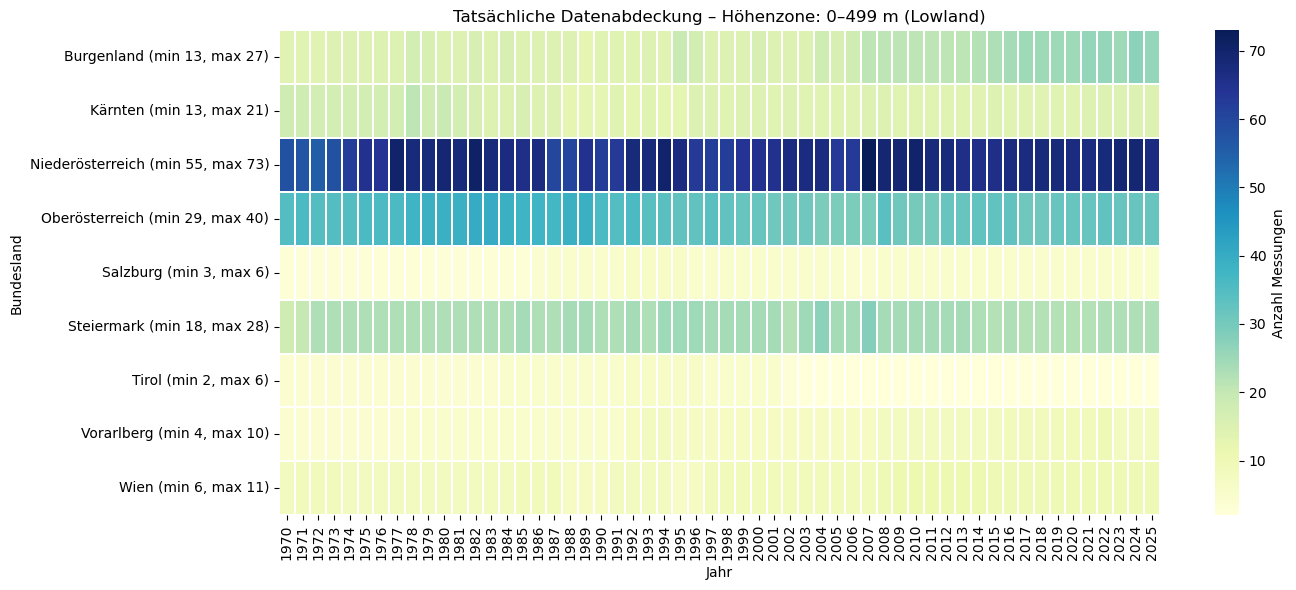

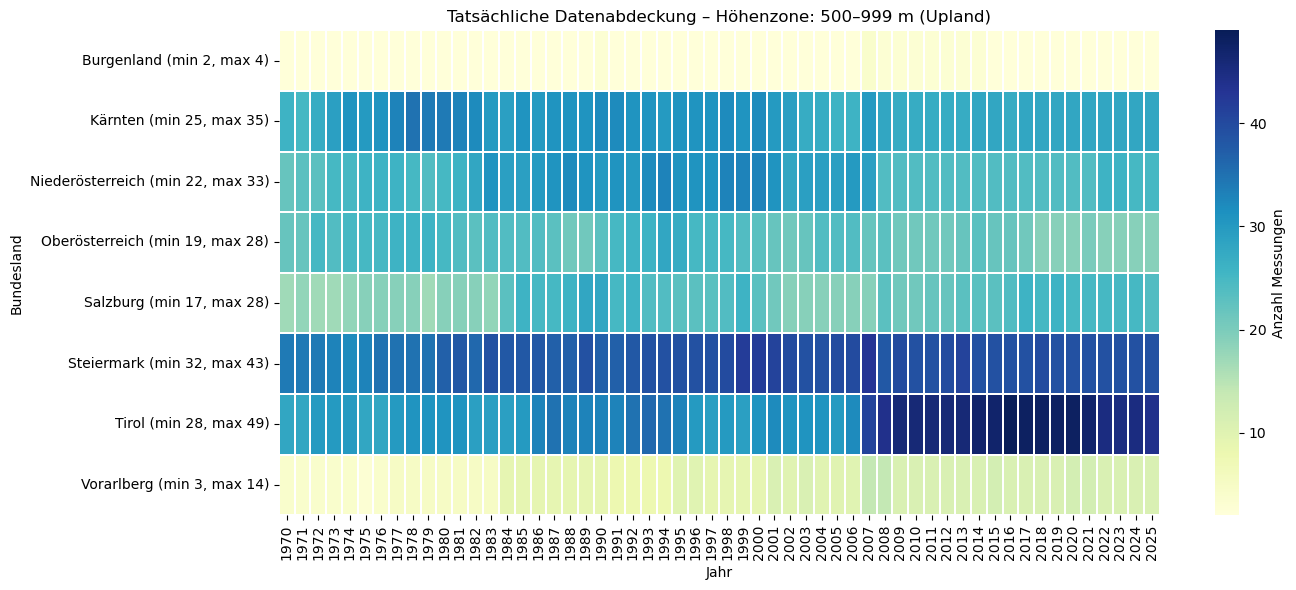

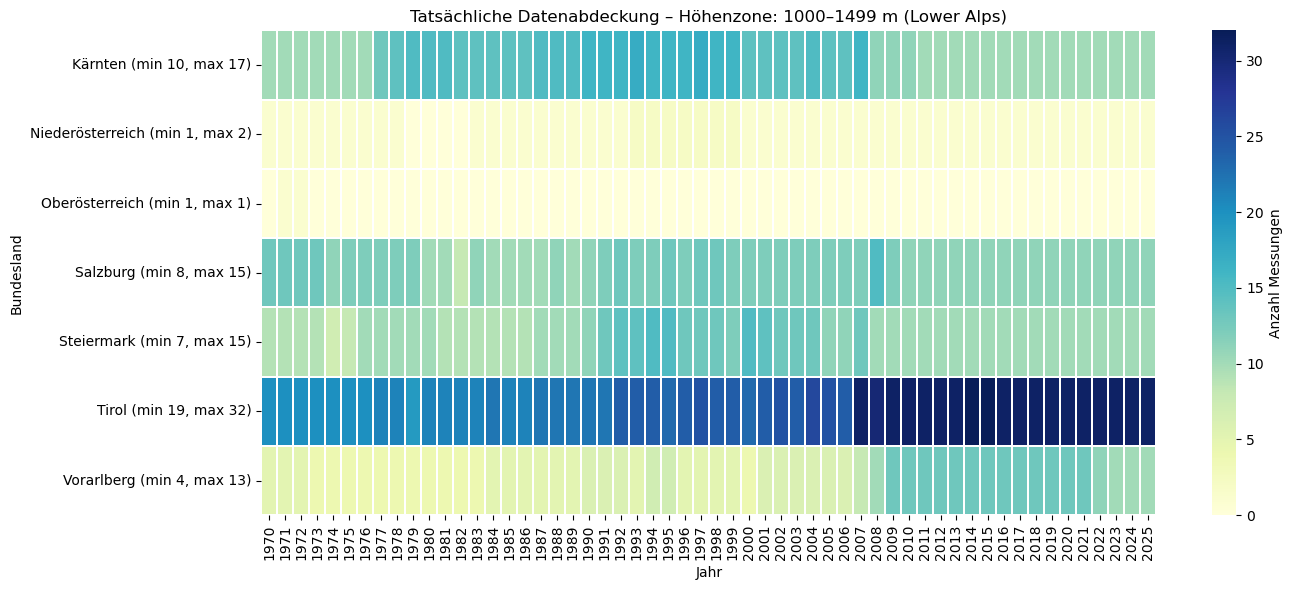

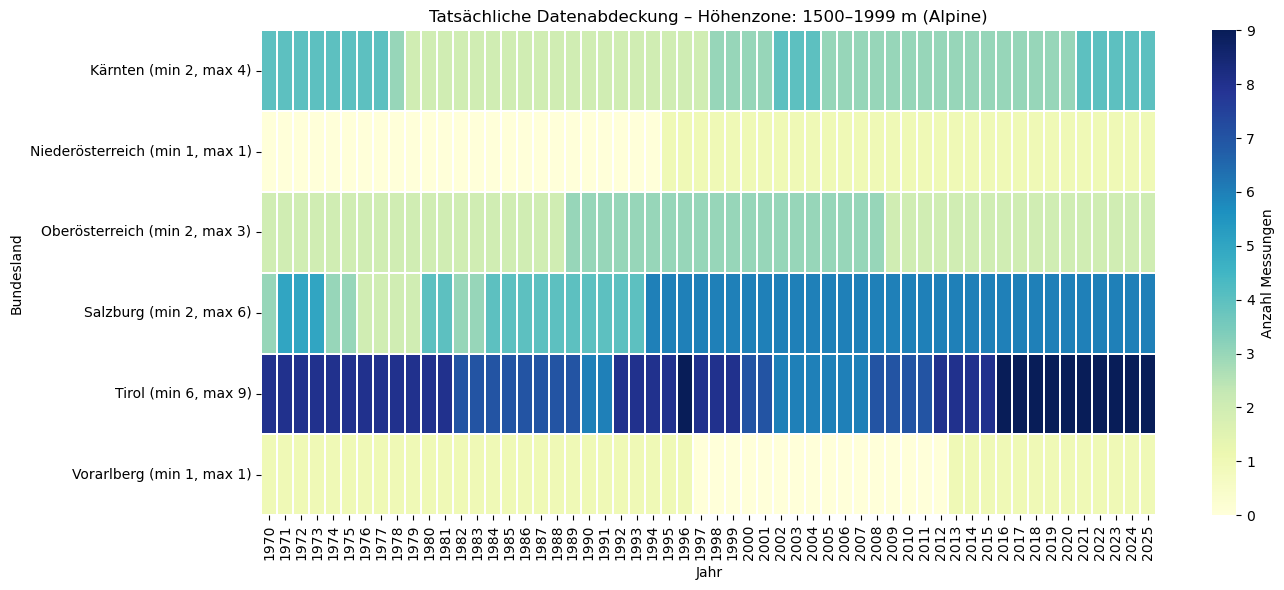

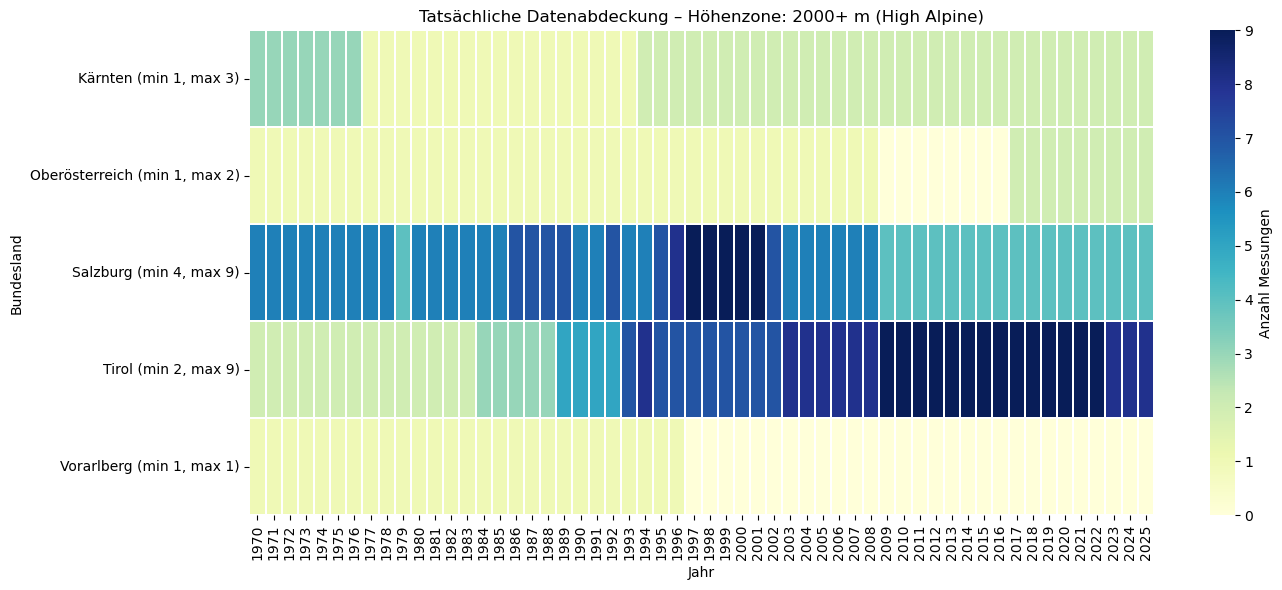

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

zone_order = [
    "0–499 m (Lowland)",
    "500–999 m (Upland)",
    "1000–1499 m (Lower Alps)",
    "1500–1999 m (Alpine)",
    "2000+ m (High Alpine)"
]

# Sortierung explizit setzen
heatmap_pd["elevation_zone"] = heatmap_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)
extrema_real_pd["elevation_zone"] = extrema_real_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)

print("Verfügbare Zonen:", heatmap_pd["elevation_zone"].dropna().unique())

for zone in [z for z in zone_order if z in heatmap_pd["elevation_zone"].unique()]:
    df_zone = heatmap_pd[heatmap_pd["elevation_zone"] == zone]
    pivot = df_zone.pivot_table(
        index="bundesland",
        columns="year",
        values="station_count",
        fill_value=0
    )

    zone_extrema = extrema_real_pd[extrema_real_pd["elevation_zone"] == zone]
    min_map = dict(zip(zone_extrema["bundesland"], zone_extrema["min_active"]))
    max_map = dict(zip(zone_extrema["bundesland"], zone_extrema["max_active"]))

    new_labels = [
        f"{b} (min {min_map.get(b, 0)}, max {max_map.get(b, 0)})"
        for b in pivot.index
    ]

    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.3,
                     cbar_kws={"label": "Anzahl Messungen"})
    ax.set_title(f"Tatsächliche Datenabdeckung – Höhenzone: {zone}")
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Bundesland")
    ax.set_yticklabels(new_labels, rotation=0)
    plt.tight_layout()
    plt.show()

In [27]:
# Liste der verwendeten Stationen aus echtem Datensatz
used_stations = df.select("station_id").distinct()

# Filtere coverage (basierend auf stations_metadata) auf nur verwendete Stationen
coverage_meta_used = coverage.join(used_stations, on="station_id", how="inner")


In [28]:
from pyspark.sql.functions import countDistinct

coverage_meta = coverage_meta_used.groupBy("year", "elevation_zone", "bundesland") \
    .agg(countDistinct("station_id").alias("count_meta"))


In [29]:
# coverage_real = df.groupBy("year", "elevation_zone", "bundesland") \
#    .agg(countDistinct("station_id").alias("count_real"))


In [30]:
from pyspark.sql.functions import expr

coverage_diff = coverage_meta.join(
    coverage_real,
    on=["year", "elevation_zone", "bundesland"],
    how="outer"
).fillna(0)

coverage_diff = coverage_diff.withColumn("diff", expr("count_meta - station_count"))


In [31]:
diff_pd = coverage_diff.toPandas()


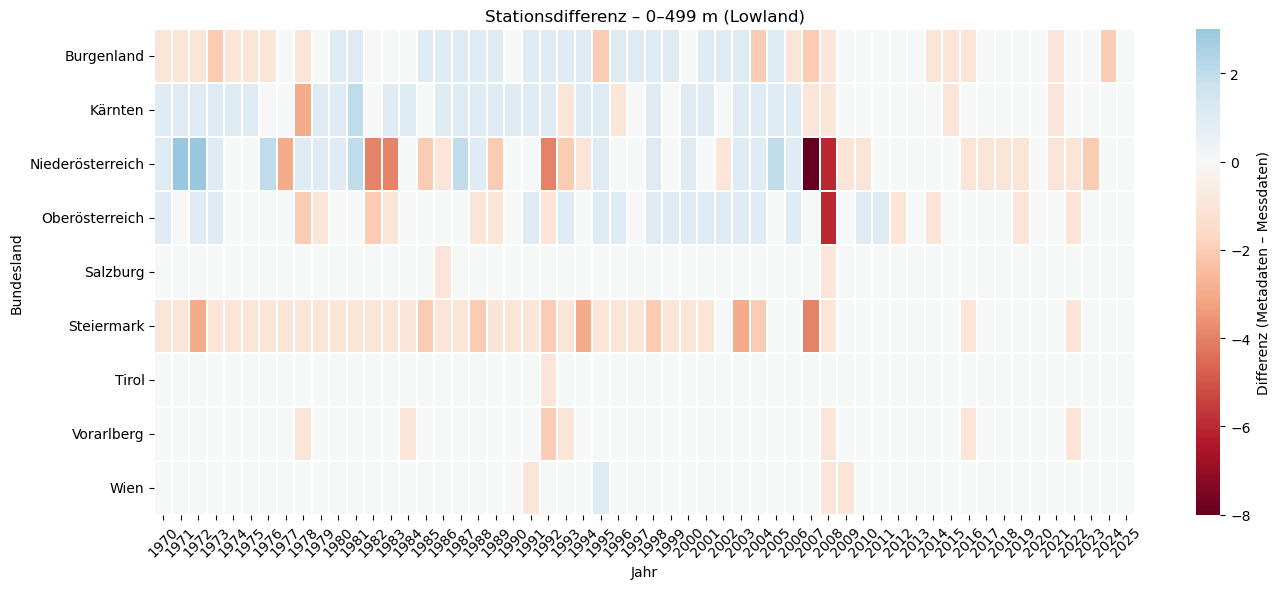

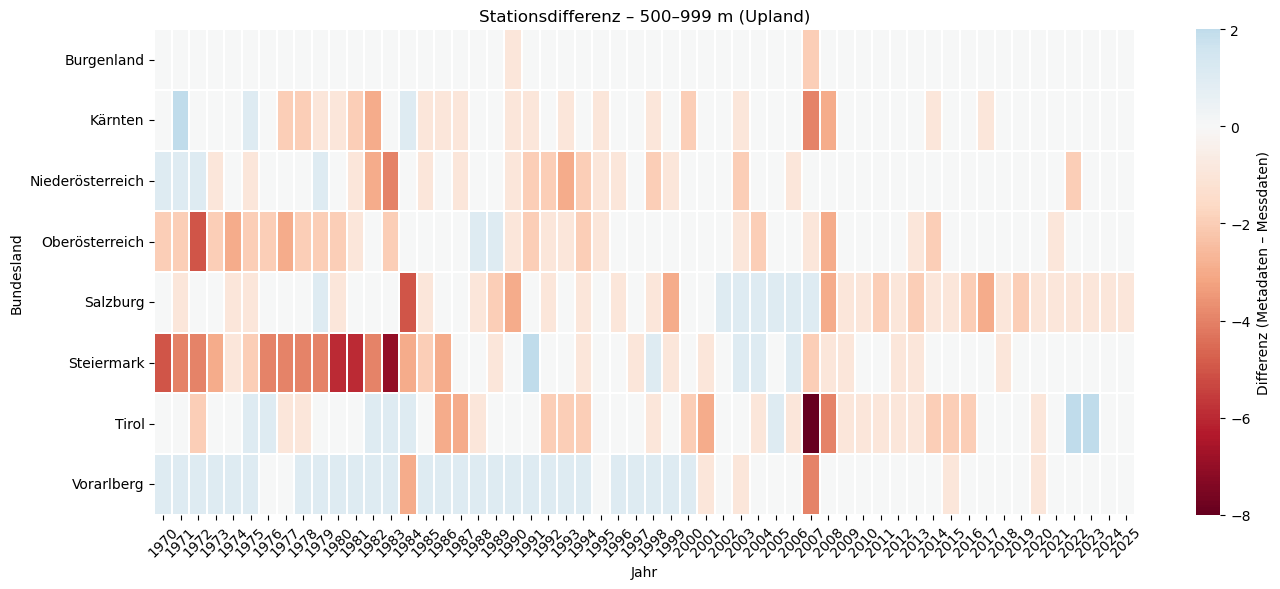

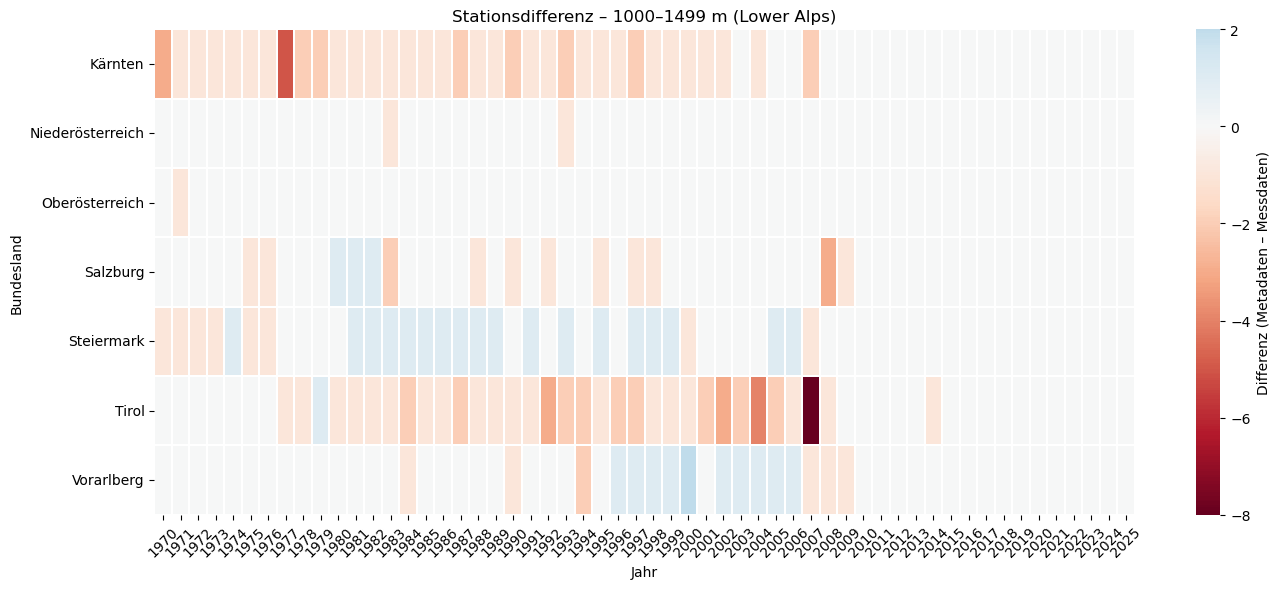

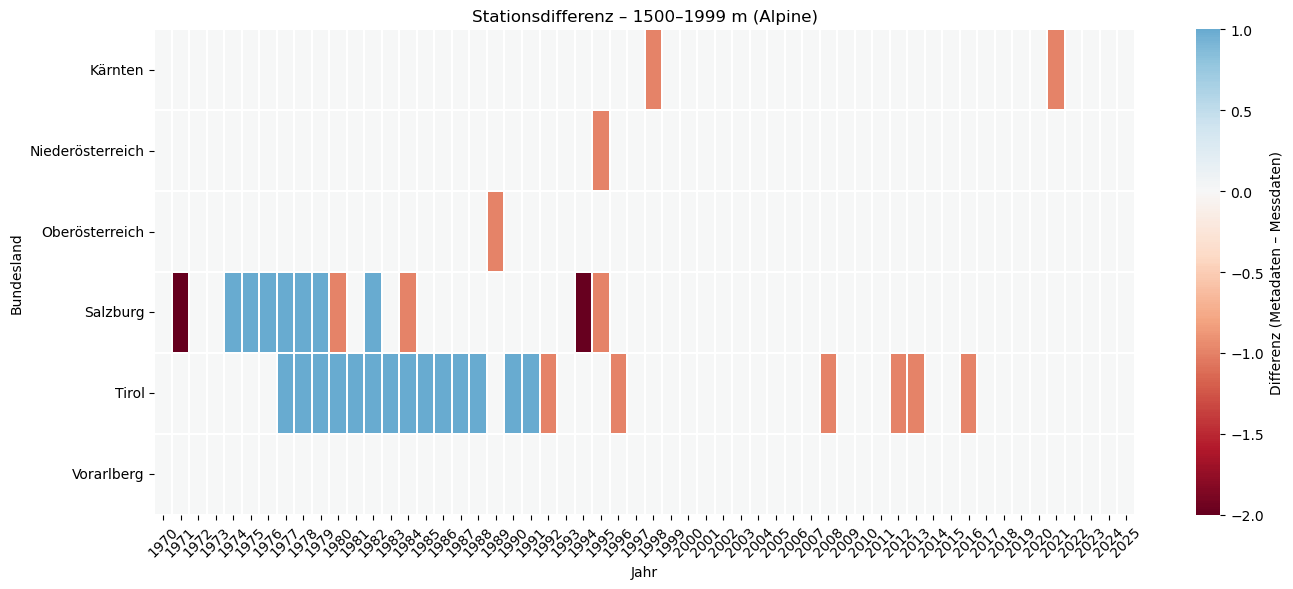

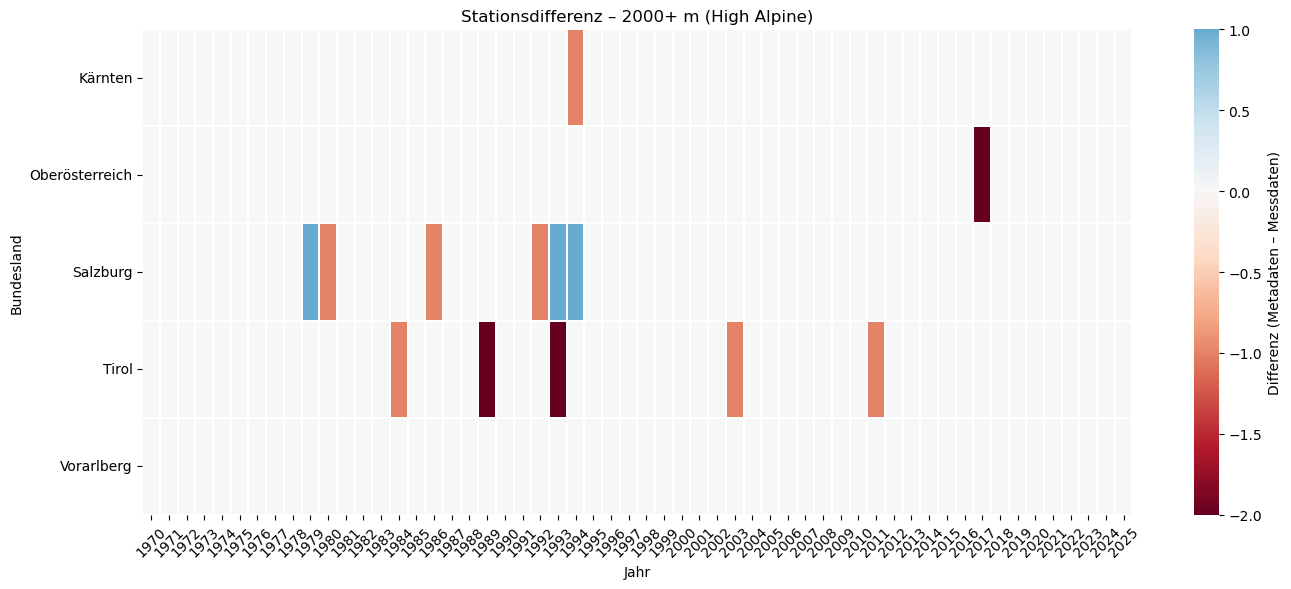

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Nur sinnvolle Jahre
diff_pd = diff_pd.query("year >= 1970")

# Höhenzonen sortieren
zone_order = [
    "0–499 m (Lowland)",
    "500–999 m (Upland)",
    "1000–1499 m (Lower Alps)",
    "1500–1999 m (Alpine)",
    "2000+ m (High Alpine)"
]

diff_pd["elevation_zone"] = diff_pd["elevation_zone"].astype(
    CategoricalDtype(categories=zone_order, ordered=True)
)

# Nur tatsächlich vorhandene Zonen
available_zones = diff_pd["elevation_zone"].dropna().unique()

for zone in zone_order:
    if zone not in available_zones:
        continue

    df_zone = diff_pd[diff_pd["elevation_zone"] == zone]
    pivot = df_zone.pivot_table(
        index="bundesland",
        columns="year",
        values="diff",
        fill_value=0
    )

    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(
        pivot,
        center=0,
        cmap="RdBu",
        linewidths=0.3,
        cbar_kws={"label": "Differenz (Metadaten – Messdaten)"}
    )
    ax.set_title(f"Stationsdifferenz – {zone}")
    ax.set_xlabel("Jahr")
    ax.set_ylabel("Bundesland")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
